In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import product

# Load and Scale Datasets

In [ ]:
#load dataset
df = pd.read_csv('weather_data.csv')
cols_to_scale = [col for col in df.columns if col not in ['Month', 'Month_Num', 'Location']]

In [23]:
#scale data
df[cols_to_scale] = StandardScaler().fit_transform(df[cols_to_scale])

# PCA

In [ ]:
#run PCA
pca = PCA(n_components=2)
principle_components = pca.fit_transform(df[cols_to_scale])
df["PC1"] = principle_components[:,0]
df["PC2"] = principle_components[:,1]

In [ ]:
#calculate explained variance
explained_variances = pca.explained_variance_ratio_
total_explained = np.sum(explained_variances)

## Plot PCA Results

Text(0.5, 1.0, 'PCA of Weather Data (Total Explained Variance: 85.1%)')

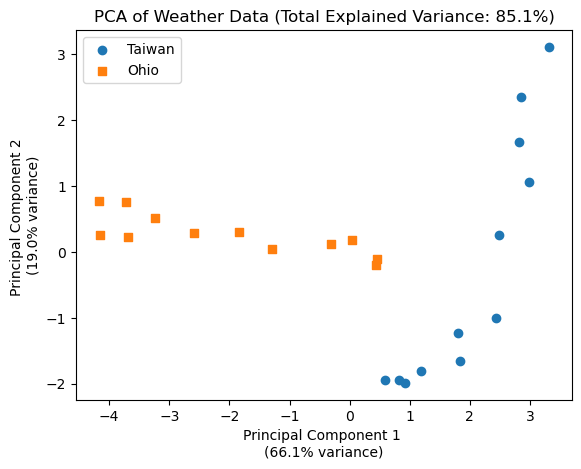

In [ ]:
#plot results on scatterplot
plt.scatter(df[df["Location"]=="TW"]["PC1"], df[df["Location"]=="TW"]["PC2"], marker = "o",label='Taiwan')
plt.scatter(df[df["Location"]=="OH"]["PC1"], df[df["Location"]=="OH"]["PC2"], marker = "s", label='Ohio')
plt.legend()
plt.xlabel(f'Principal Component 1 \n({explained_variances[0]*100:.1f}% variance)')
plt.ylabel(f'Principal Component 2 \n({explained_variances[1]*100:.1f}% variance)')
plt.title(f'PCA of Weather Data (Total Explained Variance: {total_explained*100:.1f}%)')

# Neighbor Matching

In [126]:
#make dataframe with all possible month combinations, PC1 and PC2 values for each location
Results = pd.DataFrame(list(product(df["Month_Num"].unique(), repeat = 2)),columns= ["TW_Month","OH_Month"])
Results = Results.merge(df[df["Location"]=="TW"][["Month_Num","PC1","PC2"]],left_on = "TW_Month", right_on = "Month_Num").merge(df[df["Location"]=="OH"][["Month_Num","PC1","PC2"]],left_on = "OH_Month", right_on = "Month_Num",suffixes=("_TW","_OH")).drop(columns=["Month_Num_TW","Month_Num_OH"])

In [127]:
#Compute Euclidean distances between months
Results["Distance"] = np.linalg.norm(Results[["PC1_TW","PC2_TW"]].values - Results[["PC1_OH","PC2_OH"]].values, axis=1)

In [ ]:
#find nearest match for each month in Taiwan
Matches = Results.groupby("TW_Month").agg({"Distance":"min"}).merge(Results, left_on= ["TW_Month","Distance"], right_on = ["TW_Month","Distance"])[["TW_Month","OH_Month","Distance"]]